In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from scipy.stats import zscore, pearsonr, uniform
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV
from scipy.io import loadmat
import seaborn as sns
import scipy.io

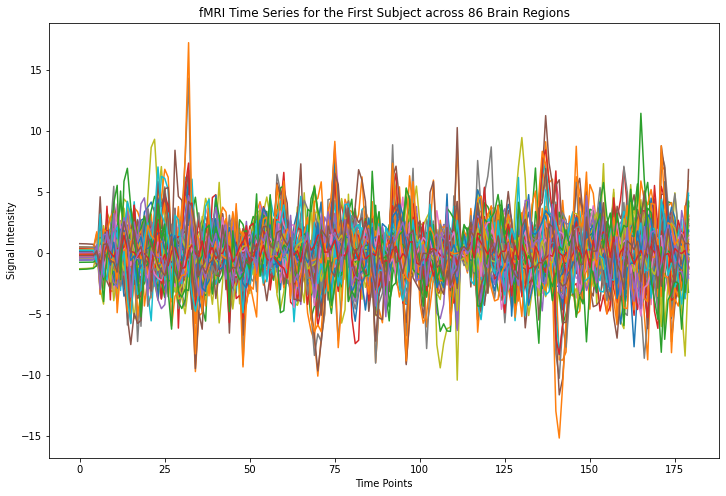

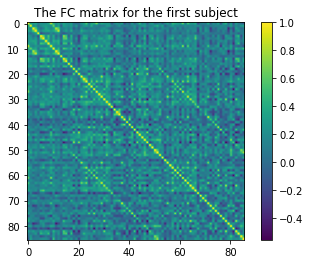

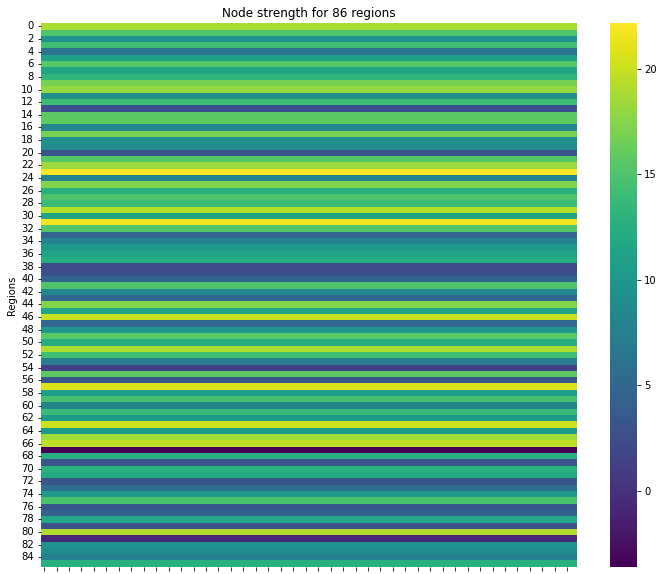

In [5]:
# Directory containing the fMRI time series data
fmri_directory = '/Users/cerentozlu/Downloads/Assignment_Python/MSdata/FMRI_time_series/'
files = os.listdir(fmri_directory)

# Load the time series data for the first subject
first_subject_file = os.path.join(fmri_directory, files[0])  
first_subject_data = scipy.io.loadmat(first_subject_file)['ts']

# Visualize the time series measured on 86 brain regions    
plt.figure(figsize=(12, 8))

# Plot the time series for each of the 86 regions
for i in range(86):
    plt.plot(first_subject_data[:, i], label=f'Region {i+1}')

plt.title('fMRI Time Series for the First Subject across 86 Brain Regions')
plt.xlabel('Time Points')
plt.ylabel('Signal Intensity')
plt.show()


# create FC matrices
FCmats = np.empty((86, 86, 420))
for i in range(len(files)):
    # Load each MS patient's fmri time series data
    TSi = loadmat(os.path.join(fmri_directory, files[i]))['ts']
    # Calculate the correlation matrix of each of the pairs of 86 regions' time series
    FCi = np.corrcoef(TSi, rowvar=False)
    FCmats[:, :, i] = FCi
    
# Visualize the FC matrix for the first subject
plt.figure()
plt.imshow(FCmats[:, :, 1])
plt.colorbar()
plt.title('The FC matrix for the first subject')

# Calculate each region's FC node strength
FC_nodestrength = np.sum(FCmats, axis=1) - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set the diagonal elements to 0
FCmats[:, :, 1][np.diag_indices(86)] = 0

# Compute the column sums
column_sums = np.sum(FCmats[:, :, 1], axis=0)

# Create a matrix with column sums for both x and y axes
column_sums_matrix = np.outer(column_sums, np.ones(86))

# Create labels for the 86 regions
region_labels = [f'Region {i+1}' for i in range(86)]

# Plot the heatmap
plt.figure(figsize=(12, 10))  # Adjust figsize as needed
ax =sns.heatmap(column_sums_matrix, cmap='viridis', cbar=True)
plt.title('Node strength for 86 regions')

# Remove x-axis label and tick labels
ax.set_xlabel('')  # Remove x-axis label
ax.set_xticklabels([])  # Remove x-axis tick labels

# Keep y-axis label and tick labels
plt.ylabel('Regions')
plt.show()


Mean correlation (FC): 0.2040
Variance explained (FC): 0.0416


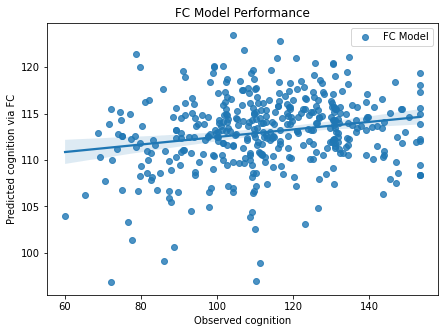

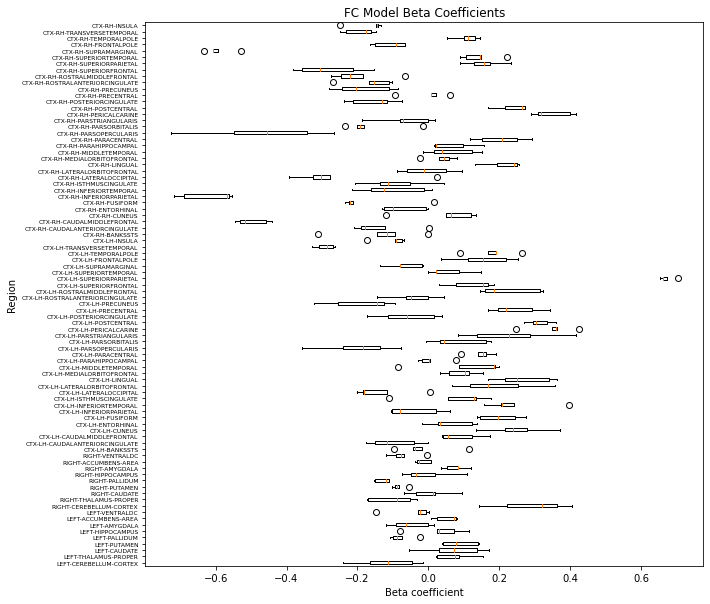

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from scipy.io import loadmat

# Load the data
fs86regionnames = loadmat('/Users/cerentozlu/Downloads/Assignment_Python/FS86ROI.mat', simplify_cells=True)['fs86regionnames']
data = loadmat('/Users/cerentozlu/Downloads/Assignment_Python/HCPdata/HCP_420.mat', simplify_cells=True)
FC = data['FC']
Total_cognition = data['Total_cognition']

# Calculate node strength for the FC matrices for the 420 individuals
X_FC = np.zeros((420, 86))
for i in range(420):
    FCi = FC[i]
    # Set diagonal entries to 0 before calculating node strength
    np.fill_diagonal(FCi, 0)
    X_FC[i] = np.sum(FCi, axis=0)

# Remove NaNs
nan_mask = ~np.isnan(Total_cognition)
y = Total_cognition[nan_mask]
X_FC = X_FC[nan_mask]

# Split the data into training and testing sets
n = len(y)
kfolds = 5
kf = KFold(n_splits=kfolds)

# Set grid search for regularization hyperparameter
hp = np.arange(0.1, 10000.1, 1000)

# create empty matrices to write the predicted cognition and beta estimates from the model
yhatFC = np.full_like(y, np.nan)
beta_maxFC = np.zeros((kfolds, 86))

# Perform nested-cross validation to tune hyperparameters and test on hold-out data
for i, (train_index, test_index) in enumerate(kf.split(X_FC)):
    Xtrain_FC, Xtest_FC = X_FC[train_index], X_FC[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    # identify the number of subjects in the train dataset
    n2 = len(ytrain)
    
    # create fold in the inner loop
    kf2 = KFold(n_splits=kfolds)

    # create empty matrix to write the correlation between the predicted and observed cognition in the inner loop
    yhat_valid_corrFC = np.zeros((kfolds, len(hp)))

    for j, (train_index2, valid_index) in enumerate(kf2.split(ytrain)):
        # create training dataset for the input
        Xtrain2_FC = Xtrain_FC[train_index2]
        # create training dataset for the output
        ytrain2, yvalid = ytrain[train_index2], ytrain[valid_index]
        
        # create empty matrix to write the predicted cognition for each hyperparameter value
        yhat_validFC = np.zeros((len(hp), len(valid_index)))

        # try different hyperparameter value and obtain the prediction accuracy
        for m, alpha in enumerate(hp):
            ridgeFC = Ridge(alpha=alpha)
            ridgeFC.fit(Xtrain2_FC, ytrain2)
            yhat_validFC[m] = ridgeFC.predict(Xtrain_FC[valid_index])

            yhat_valid_corrFC[j, m] = np.corrcoef(yhat_validFC[m], yvalid)[0, 1]

    # create the average accuracy across 5 validation datasets
    mean_yhat_corrFC = np.mean(yhat_valid_corrFC, axis=0)
    # find the best hyperparameter that maximize the prediction accuracy (correlation)
    max_hpFC = hp[np.argmax(mean_yhat_corrFC)]

    # fit the model using the best hyperparameter
    ridge_maxFC = Ridge(alpha=max_hpFC)
    ridge_maxFC.fit(Xtrain_FC, ytrain)

    # test the model using the test dataset
    yhatFC[test_index] = ridge_maxFC.predict(Xtest_FC)
    beta_maxFC[i, :] = ridge_maxFC.coef_

# Calculate the mean correlation/r-squared over 5 hold out test sets
yhat_corrFC = np.corrcoef(yhatFC, y)[0, 1]
yhat_varexplainFC = 1 - np.sum((yhatFC - y) ** 2) / np.sum((y - np.mean(y)) ** 2)

print(f"Mean correlation (FC): {yhat_corrFC:.4f}")
print(f"Variance explained (FC): {yhat_varexplainFC:.4f}")

# Plot the predicted versus the observed values to assess model performance
plt.figure(figsize=(7, 5))
sns.regplot(x=y, y=yhatFC, label='FC Model')
plt.xlabel('Observed cognition')
plt.ylabel('Predicted cognition via FC')
plt.title('FC Model Performance')
plt.legend()
plt.show()

# Visualize the beta coefficients over the 5 folds for the FC model
plt.figure(figsize=(10, 10))
plt.boxplot(beta_maxFC, vert=False, labels=fs86regionnames)
plt.yticks(fontsize=6)
plt.ylabel('Region')
plt.xlabel('Beta coefficient')
plt.title('FC Model Beta Coefficients')
plt.show()